In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
print("TF  Version",tf.__version__)

TF  Version 2.2.0


Using TensorFlow backend.


In [2]:
# check and set path before loading modules
INPUT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
OUTPUT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != OUTPUT_DIR:
    os.chdir(OUTPUT_DIR)
    
import functions_model_definition as md
import functions_read_data as rdat
import functions_slider as sl
#weights tuning functions
import ens_weights_tuning as w_tune

#ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters

In [3]:
# Define Version
version = "CIBLSX" # one of:
#version = "CIB" # one of:

# Define Model Version
model_version = 3

# Select naming convention (for CIBLSX model_version >= 3 should be False)
comp_mode = False # if True: use old naming convention

# define paths
DATA_DIR, WEIGHT_DIR, DATA_OUTPUT_DIR, PIC_OUTPUT_DIR, pic_save_name = rdat.dir_setup(
    INPUT_DIR, OUTPUT_DIR, version, model_version, 
    compatibility_mode=comp_mode)

save_csv = False

In [4]:
## load images and ids
(X_in, pat_ids, id_tab, all_results_tab, pat_orig_tab, pat_norm_tab, num_models) = rdat.version_setup(
    DATA_DIR = DATA_DIR, 
    version = version, 
    model_version = model_version,
    compatibility_mode=comp_mode)

In [5]:
# define model
(input_dim_img, output_dim, LOSS, layer_connection, last_activation) = md.model_setup(version)

model_3d = md.model_init(
    version = version, 
    output_dim = output_dim,
    LOSS = LOSS,
    layer_connection = layer_connection,
    last_activation = last_activation,
    C = 2,
    learning_rate = 5*1e-5,
    batch_size = 6,
    input_dim = input_dim_img,
    input_dim_tab = pat_norm_tab.drop(columns=["p_id"]).shape[1] if "LSX" in version else None,
)

In [6]:
# Define Model Name
generate_model_name = md.set_generate_model_name(
    model_version = model_version, 
    layer_connection = layer_connection, 
    last_activation = last_activation, 
    path = WEIGHT_DIR,
    compatability_mode=comp_mode)  

In [7]:
model_nrs = list(range(5)) #num of ensembles
which_splits = list(range(0,10)) # 10 Fold

In [8]:
results_list = [] 
valid_list = [] 
weights = []
betas = []

for which_split in which_splits:
    data_split = rdat.split_data(id_tab, X_in, which_split, X_tab = pat_norm_tab)

    X_valid = np.expand_dims(data_split["X"]["valid"], axis=-1)
    X_test = np.expand_dims(data_split["X"]["test"], axis=-1)
    Y_valid = to_categorical(data_split["y"]["valid"])
    Y_test = to_categorical(data_split["y"]["test"])

    if pat_norm_tab is not None:
        X_tab_test = data_split["X_tab"]["test"]    
        X_tab_valid = data_split["X_tab"]["valid"]
        test_data = tf.data.Dataset.from_tensor_slices((X_test, X_tab_test))
        valid_data = tf.data.Dataset.from_tensor_slices((X_valid, X_tab_valid))
        shift_params = []
    else:
        X_tab_test = None
        X_tab_valid = None
        test_data = tf.data.Dataset.from_tensor_slices((X_test))
        valid_data = tf.data.Dataset.from_tensor_slices((X_valid))
        shift_params = None

    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    test_dataset_pred = (test_loader.batch(len(X_test)))

    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))
    valid_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    valid_dataset_pred = (valid_loader.batch(len(X_valid)))  

    results = id_tab[id_tab["fold" + str(which_split)] == "test"].copy()       
    results["test_split"] = which_split        
        
    validation_results = pd.DataFrame(
            {"test_split": which_split,
            "unfavorable": data_split["y"]["valid"]})
      
    y_test_preds = []
    y_valid_preds = []   
    intercepts_test = []
    intercepts_val = []
    
    for model_nr in model_nrs:
        model_3d.load_weights(generate_model_name(which_split, model_nr))

        #test
        predic = predict_ontram(model_3d, data = test_dataset_pred)['pdf'][:,1]
        y_test_preds.append(predic.squeeze())
        results["y_pred_model_" + str(model_nr)] = y_test_preds[-1]

        #valid
        predicc = predict_ontram(model_3d, data = valid_dataset_pred)['pdf'][:,1]
        y_valid_preds.append(predicc.squeeze())
        validation_results["y_pred_model_" + str(model_nr)] = y_valid_preds[-1]   

        # Save Intercepts for tuning
        #test
        preds_test = model_3d.predict(test_dataset_pred)
        intercepts_test.append(preds_test[:, 0])
        #valid
        preds_val = model_3d.predict(valid_dataset_pred)
        intercepts_val.append(preds_val[:, 0])

        # Save shift parameters if CIB_LSX
        if shift_params is not None:
            shift_params.append(get_parameters(model_3d)['shift'][0][0][0])       

    y_test_preds = np.array(y_test_preds)
    y_valid_preds = np.array(y_valid_preds) 

    weigths_tuned = w_tune.get_w(intercepts = intercepts_val,
                             y_true = data_split["y"]["valid"],
                             shift = shift_params,
                             X_tab = X_tab_valid)
    
    for model_nr in model_nrs:
        results[f'weight_model_{model_nr}'] = weigths_tuned[model_nr]
        validation_results[f'weight_model_{model_nr}'] = weigths_tuned[model_nr]

    results["y_pred_trafo_avg"] = w_tune.get_ensemble(intercepts = intercepts_test, 
                                                      shift = shift_params, 
                                                      X_tab = X_tab_test, 
                                                      weights=None)
    
    results["y_pred_trafo_avg_w"] = w_tune.get_ensemble(intercepts = intercepts_test, 
                                                      shift = shift_params, 
                                                      X_tab = X_tab_test, 
                                                      weights=weigths_tuned)
    
    validation_results["y_pred_trafo_avg"] = w_tune.get_ensemble(intercepts = intercepts_val, 
                                                      shift = shift_params, 
                                                      X_tab = X_tab_valid, 
                                                      weights=None) 
    
    validation_results["y_pred_trafo_avg_w"] = w_tune.get_ensemble(intercepts = intercepts_val, 
                                                      shift = shift_params, 
                                                      X_tab = X_tab_valid, 
                                                      weights=weigths_tuned)
    
    results_list.append(results)
    valid_list.append(validation_results)
    betas.append(shift_params)

## Calculate Threshold

Calculation of threshold for classification is done on validation data. Then applied to the test data.

In [9]:
valid_thresholds_avg = []
valid_thresholds_avg_w = []

for i, validation_results in enumerate(valid_list):
  
    y_org = validation_results["unfavorable"]
    y_pred_avg = validation_results["y_pred_trafo_avg"]
    y_pred_avg_w = validation_results["y_pred_trafo_avg_w"]
  
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred_avg)
    fpr_w, tpr_w, threshold_w = metrics.roc_curve(y_org, y_pred_avg_w)

    #auc
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_w = metrics.auc(fpr_w, tpr_w)
    
    # calculate geometric mean of tpr and fpr to find best threshold
    gmean = np.sqrt(tpr * (1 - fpr))
    gmean_w = np.sqrt(tpr_w * (1 - fpr_w))

    # Find the optimal threshold
    index = np.argmax(gmean)
    index_w = np.argmax(gmean_w)

    valid_thresholds_avg.append(threshold[index])
    valid_thresholds_avg_w.append(threshold_w[index_w])

### Apply Threshold to Testdata

In [10]:
for i, results in enumerate(results_list):
    results["threshold_avg"] = valid_thresholds_avg[i]
    results["threshold_avg_w"] = valid_thresholds_avg_w[i]
    
    results["y_pred_class_avg"] = (results["y_pred_trafo_avg"] >= results["threshold_avg"]).astype(int)
    results["y_pred_class_avg_w"] = (results["y_pred_trafo_avg_w"] >= results["threshold_avg_w"]).astype(int)

#### Concat all Pandas and Analyze

In [11]:
all_results = pd.concat(results_list)

## Calculate Model Uncertainty

Use the standard deviation of the predictions as a measure of uncertainty. Then use min max normalization to scale the uncertainty between 0 and 1.  
Compare the uncertainty with the predictions

In [12]:
all_results["y_pred_std"] = all_results[["y_pred_model_" + str(i) for i in range(5)]].std(axis = 1)
all_results["y_pred_unc"] = (all_results["y_pred_std"] - all_results.y_pred_std.min()) / (
    all_results.y_pred_std.max() - all_results.y_pred_std.min())

In [13]:
weighted_means = np.average(all_results[["y_pred_model_" + str(i) for i in range(5)]],
                            weights=all_results[["weight_model_" + str(i) for i in range(5)]],
                            axis=1)

weighted_var = np.average((all_results[["y_pred_model_" + str(i) for i in range(5)]] - weighted_means[:, np.newaxis])**2,
                                         weights=all_results[["weight_model_" + str(i) for i in range(5)]],
                                         axis=1)

all_results["y_pred_std_w"] = np.sqrt(weighted_var)

all_results["y_pred_unc_w"] = (all_results["y_pred_std_w"] - all_results["y_pred_std_w"].min()) / (
        all_results["y_pred_std_w"].max() - all_results["y_pred_std_w"].min())

In [14]:
all_results["pred_correct"] = all_results["y_pred_class_avg"] == all_results["unfavorable"] 
all_results["pred_correct_w"] = all_results["y_pred_class_avg_w"] == all_results["unfavorable"] 

# Save

In [15]:
if not comp_mode:
    res_name = DATA_DIR + "all_tab_results_" + version + "_M" + str(model_version) + ".csv" # 10 Fold

elif comp_mode:
    res_name = DATA_DIR + "all_tab_results_10Fold_" + version + "_M" + str(model_version) + ".csv"

In [16]:
res_name

'/tf/notebooks/schnemau/xAI_stroke_3d/data/all_tab_results_CIBLSX_M3.csv'

In [17]:
if save_csv == True:
    all_results.to_csv(res_name,  index=False) 

# Plot Shift Parameters

In [17]:
betas2 = np.array(betas)

In [18]:
import numpy as np

# Example data (replace with your actual data)
num_levels = 10
num_sublevels = 5
num_parameters = 13

means_per_level = np.mean(betas2, axis=1)
means_per_parameter = means_per_level.transpose(1, 0, 2).reshape(num_parameters, num_levels)

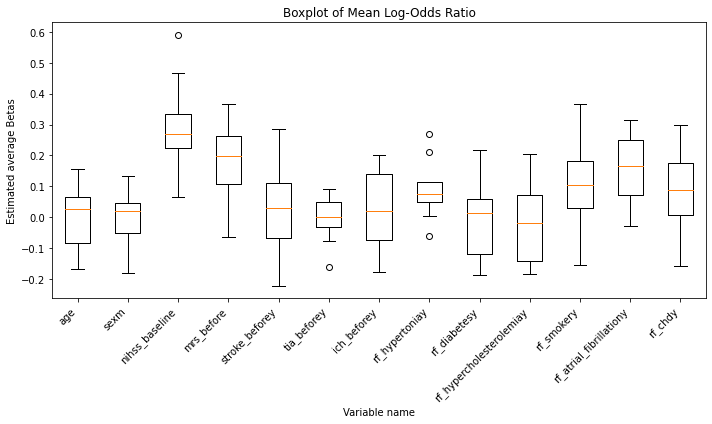

In [19]:
variable_names = ["age", "sexm", "nihss_baseline", "mrs_before",
                  "stroke_beforey", "tia_beforey", "ich_beforey", 
                  "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                  "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]

# Plotting boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(means_per_parameter.T, labels=variable_names)
plt.title('Boxplot of Mean Log-Odds Ratio')
plt.xlabel('Variable name')
plt.ylabel('Estimated average Betas')
plt.grid(False)  # Remove grid lines
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Evaluation metrics

In [20]:
y_true = all_results["unfavorable"]
y_pred_binary = all_results["y_pred_class_avg"]
y_pred_binary_w = all_results["y_pred_class_avg_w"]

y_pred_trafo_avg = all_results["y_pred_trafo_avg"]
y_pred_trafo_avg_w = all_results["y_pred_trafo_avg_w"]

# Calculate metrics average weighted
f1_value = metrics.f1_score(y_true, y_pred_binary)
sensitivity = metrics.recall_score(y_true, y_pred_binary)
specificity = metrics.recall_score(y_true, y_pred_binary, pos_label=0)
auc_value = metrics.roc_auc_score(y_true, y_pred_trafo_avg)
log_li = metrics.log_loss(y_true, y_pred_trafo_avg)

# Calculate metrics tuned weighted average
f1_value_w = metrics.f1_score(y_true, y_pred_binary_w)
sensitivity_w = metrics.recall_score(y_true, y_pred_binary_w)
specificity_w = metrics.recall_score(y_true, y_pred_binary_w, pos_label=0)
auc_value_w = metrics.roc_auc_score(y_true, y_pred_trafo_avg_w)
log_li_w = metrics.log_loss(y_true, y_pred_trafo_avg_w)

# Display results 1
print("---Trafo Average:---")
print("F1-Value:", round(f1_value,4))
print("Sensitivity:", round(sensitivity,4))
print("Specificity:", round(specificity,4))
print("AUC:", round(auc_value,4))
print("Negative Log-Likelihood:", round(log_li,4))

print("---------------------------------------------")

# Display results 2
print("---Trafo Average weighted tuned:---")
print("F1-Value:", round(f1_value_w,4))
print("Sensitivity:", round(sensitivity_w,4))
print("Specificity:", round(specificity_w,4))
print("AUC:", round(auc_value_w,4))
print("Negative Log-Likelihood:", round(log_li_w,4))

---Trafo Average:---
F1-Value: 0.4894
Sensitivity: 0.6133
Specificity: 0.7982
AUC: 0.7917
Negative Log-Likelihood: 0.4047
---------------------------------------------
---Trafo Average weighted tuned:---
F1-Value: 0.4804
Sensitivity: 0.5733
Specificity: 0.8163
AUC: 0.7701
Negative Log-Likelihood: 0.4178
